In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/My Drive/Cardiac Project/

/content/drive/.shortcut-targets-by-id/1T4XU2DwFBpucge5DbMQ0wVZaRLkXQ564/Cardiac Project


In [3]:
!pip install simpleitk -q
!pip install ipywidgets -q
!pip install tqdm -q

     |████████████████████████████████| 47.4MB 84kB/s 


In [5]:
import os
import cv2
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage import exposure
from skimage import img_as_float

# imports from file
from scripts import *

In [6]:
cine = cv2.imread("./pair_selected/ok3/1607269/2/img0021-105.824_cine.png")
lge_befor = cv2.imread("./pair_selected/ok3/1607269/2/img0008--103.848_lge.png")
lge_after  = cv2.imread("./pair_selected/ok3/1607269/2/img0008--103.848_lge_affined.png")

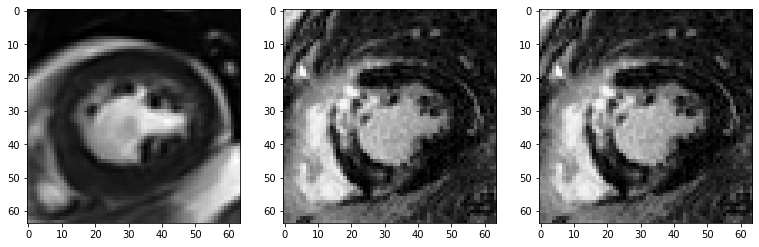

In [ ]:
fig , (ax1 , ax2 , ax3  ) = plt.subplots(1,3, figsize=(13,10))
ax1.imshow(cine, cmap = 'gray')
ax2.imshow(lge_befor, cmap = 'gray')
ax3.imshow(lge_after, cmap = 'gray')


In [7]:
import os
import sys 
import SimpleITK as sitk
from IPython.display import clear_output

%matplotlib inline
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed

# Simple ITK

In [170]:
# Reading Dataset
dataset = read_dataset('pair_selected/ok5/1516218/')

# Histogram Matching
matched_dataset = Histogram_Matching(dataset)

# Crop images using BB
cropped_dataset = crop_bb(matched_dataset)

meta data readed.
images readed.


In [171]:
len(cropped_dataset)

6

In [199]:
instance_number = 3

In [200]:
fixed_image = cropped_dataset[instance_number][0][0]
moving_image = cropped_dataset[instance_number][1][0]
cine_destination = cropped_dataset[instance_number][0][3][:-4] + '_cine.png'
lge_destination = cropped_dataset[instance_number][1][3][:-4] + '_lge.png'
lge_affined_destination = cropped_dataset[instance_number][1][3][:-4] + '_lge_affined.png'
print(cine_destination)
print(lge_destination)


pair_selected/ok5/1516218/2/img0022-86.9313_cine.png
pair_selected/ok5/1516218/2/img0006-84.2511_lge.png


In [201]:
fixed = sitk.GetImageFromArray(fixed_image)
fixed = sitk.Cast(fixed, sitk.sitkFloat32)
moving = sitk.GetImageFromArray(moving_image)
moving = sitk.Cast(moving, sitk.sitkFloat32)

In [206]:
tx = sitk.CenteredTransformInitializer(fixed, moving,
                                       sitk.Similarity2DTransform())
R = sitk.ImageRegistrationMethod()
R.SetMetricAsCorrelation()
R.SetOptimizerAsRegularStepGradientDescent(0.01, 1e-9, 4000)
R.SetInitialTransform(tx)
R.SetInterpolator(sitk.sitkLinear)

In [207]:
outTx = R.Execute(fixed, moving)

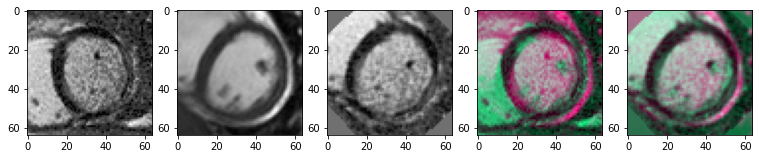

In [208]:
resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixed)
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(100)
resampler.SetTransform(outTx)

out = resampler.Execute(moving)
fix = sitk.GetArrayFromImage(sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8))
mov = sitk.GetArrayFromImage(sitk.Cast(sitk.RescaleIntensity(moving), sitk.sitkUInt8))
outt = sitk.GetArrayFromImage(sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8))
befor = sitk.GetArrayFromImage(sitk.Compose(sitk.GetImageFromArray(fix), sitk.GetImageFromArray(mov), sitk.GetImageFromArray(fix) // 2. + sitk.GetImageFromArray(mov) // 2.))
after = sitk.GetArrayFromImage(sitk.Compose(sitk.GetImageFromArray(fix), sitk.GetImageFromArray(outt), sitk.GetImageFromArray(fix) // 2. + sitk.GetImageFromArray(outt) // 2.))


fig , (ax1 , ax2 , ax3 , ax4 , ax5 ) = plt.subplots(1,5, figsize=(13,10))
ax1.imshow(mov, cmap = 'gray')
ax2.imshow(fix, cmap = 'gray')
ax3.imshow(outt, cmap = 'gray')
ax4.imshow(befor, cmap = 'gray')
ax5.imshow(after, cmap = 'gray')

plt.show()

In [210]:
cv2.imwrite(cine_destination , fix)
cv2.imwrite(lge_destination , mov)
cv2.imwrite(lge_affined_destination , outt)

True

# ECC

In [178]:
def get_gradient(im) :
    # Calculate the x and y gradients using Sobel operator
    grad_x = cv2.Sobel(im,cv2.CV_32F,1,0,ksize=5)
    grad_y = cv2.Sobel(im,cv2.CV_32F,0,1,ksize=5)

    # Combine the two gradients
    grad = cv2.addWeighted(np.absolute(grad_x), 0.5, np.absolute(grad_y), 0.5, 0)
    return grad

def ECC(fixed_image , moving_image , warp_mode = cv2.MOTION_AFFINE , warp_matrix = False):
    sz = fixed_image.shape

    number_of_iterations = 20000
    termination_eps = 1e-8
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)
    
    im1 = get_gradient(fixed_image)
    im2 = get_gradient(moving_image)

    ########################################## STEP 1 cv2.MOTION_EUCLIDEAN 
    warp_mode = cv2.MOTION_EUCLIDEAN   
    warp_matrix = np.eye(2, 3, dtype=np.float32)
    (cc, warp_matrix) = cv2.findTransformECC(im1, im2, warp_matrix, warp_mode, criteria, inputMask=None , gaussFiltSize=1)
    
    ########################################## STEP 2 cv2.MOTION_AFFINE 
    warp_mode = cv2.MOTION_AFFINE 
    (cc, warp_matrix) = cv2.findTransformECC(im1, im2, warp_matrix, warp_mode, criteria, inputMask=None , gaussFiltSize=1)
    im2_aligned = cv2.warpAffine(moving_image, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    return im2_aligned 

In [179]:
def preprocess(dataset):
    for cine_item , lge_item in dataset:
        fixed_image = cine_item[0]
        moving_image = lge_item[0]     
        affiend = ECC(fixed_image , moving_image)
        
        # sjow images
        fig , (ax1 , ax2 , ax3 ) = plt.subplots(1,3, figsize=(10,10))
        ax1.imshow(moving_image, cmap = 'gray')
        ax2.imshow(fixed_image, cmap = 'gray')
        ax3.imshow(affiend, cmap = 'gray')
        plt.show()
        print(cine_item[3])
        cine_destination = cine_item[3][:-4] + '_cine.png'
        lge_destination = lge_item[3][:-4] + '_lge.png'
        lge_affined_destination = lge_item[3][:-4] + '_lge_affined.png'
        folder_num = cine_destination.split('/')[3]
        if folder_num in []:
            print("True")
            cv2.imwrite(cine_destination , fixed_image)
            cv2.imwrite(lge_destination , moving_image)
            cv2.imwrite(lge_affined_destination , affiend)

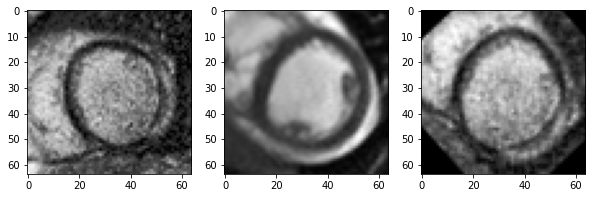

pair_selected/ok5/1516218/4/img0022-105.331.png


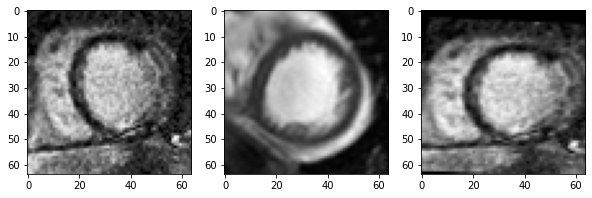

pair_selected/ok5/1516218/5/img0022-114.531.png


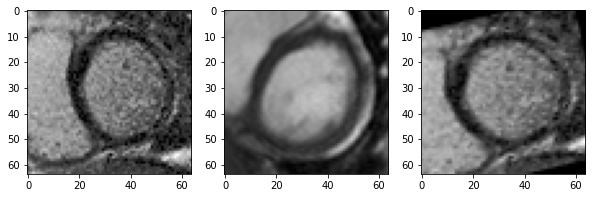

pair_selected/ok5/1516218/1/img0022-77.7313.png


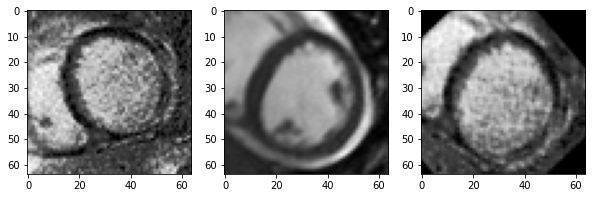

pair_selected/ok5/1516218/3/img0022-96.1313.png


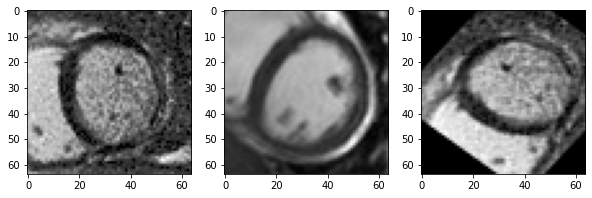

pair_selected/ok5/1516218/2/img0022-86.9313.png


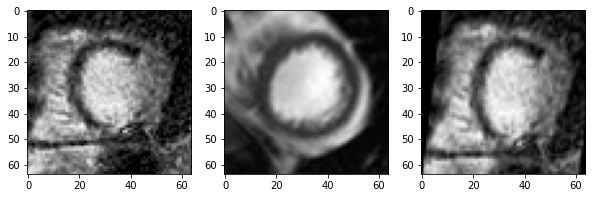

pair_selected/ok5/1516218/6/img0022-123.731.png


In [180]:
preprocess(cropped_dataset)

In [ ]:
# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2,figsize=(10,8))
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa,cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa,cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')
    
    plt.show()
    
    
# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space. 
def display_images_with_alpha(alpha, fixed, moving):
    img = (1.0 - alpha)*fixed + alpha*moving 
    plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()
    
    
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

In [ ]:
#fixed_image = img_as_float(fixed_image)
#aligned_img = img_as_float(aligned_img)
#fixed_image = sitk.GetImageFromArray(fixed_image)
#moving_image = sitk.GetImageFromArray(aligned_img)


### t2: b-spline1 + SetOptimizerAsLBFGSB

In [ ]:
fixed_image = cv2.resize(cv2.imread("Registration phase/im1.jpg" , cv2.IMREAD_GRAYSCALE) , (200 ,200))
moving_image = cv2.resize(cv2.imread("Registration phase/im2.jpg" , cv2.IMREAD_GRAYSCALE ) , (200,200))
fixed_image = img_as_float(fixed_image)
moving_image = img_as_float(moving_image)
fixed_image = sitk.GetImageFromArray(fixed_image)
moving_image = sitk.GetImageFromArray(moving_image)

In [ ]:
from __future__ import print_function

import SimpleITK as sitk
import sys
import os



def register2(fixed, moving, fixed_image_mask=None, fixed_points=None, moving_points=None):
    transformDomainMeshSize=[10]*fixed.GetDimension()
    tx = sitk.BSplineTransformInitializer(fixed,transformDomainMeshSize,order=3 )

    print("Initial Number of Parameters: {0}".format(tx.GetNumberOfParameters()))

    R = sitk.ImageRegistrationMethod()
    #R.SetMetricAsJointHistogramMutualInformation()
    R.SetMetricAsMeanSquares()

    R.SetOptimizerAsGradientDescentLineSearch(5.0,50,
                                            convergenceMinimumValue=1e-5,
                                            convergenceWindowSize=5)

    R.SetInterpolator(sitk.sitkLinear)

    #R.SetInitialTransformAsBSpline(tx,inPlace=True,scaleFactors=[1,2,5])
    R.SetInitialTransform(tx)
    #R.SetShrinkFactorsPerLevel([6,2,1])
    #R.SetSmoothingSigmasPerLevel([6,2,1])

    outTx = R.Execute(fixed, moving)
    return outTx

In [ ]:
def create_result(fixed_image , moving_image , transform):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed_image)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(100)
    resampler.SetTransform(transform)

    out = resampler.Execute(moving_image)
    simg1 = sitk.Cast(sitk.RescaleIntensity(fixed_image), sitk.sitkUInt8)
    simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
    cimg = sitk.Compose(simg1, simg2, simg1 //2 + simg2//2 )
    return simg2 , cimg

Initial Number of Parameters: 338


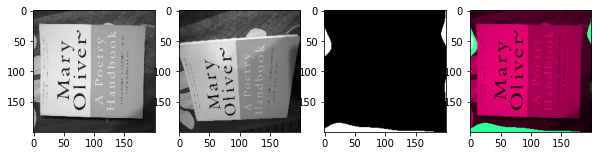

In [ ]:
#tr2 = bspline1(fixed_image, moving_image)
tr2 = register2(fixed_image, moving_image)
t2 , c2  = create_result(fixed_image , moving_image , tr2)
fig , (ax1 , ax2  ,ax3 , ax4) = plt.subplots(1 , 4 , figsize = (10,15))
ax1.imshow(sitk.GetArrayFromImage(fixed_image) , cmap = 'gray')
ax2.imshow(sitk.GetArrayFromImage(moving_image), cmap = 'gray')
ax3.imshow(sitk.GetArrayFromImage(t2) , cmap = 'gray')
ax4.imshow(sitk.GetArrayFromImage(c2) , cmap = 'gray')

In [ ]:
def bspline_intra_modal_registration(fixed_image, moving_image, fixed_image_mask=None, fixed_points=None, moving_points=None):

    registration_method = sitk.ImageRegistrationMethod()
    
    # Determine the number of BSpline control points using the physical spacing we want for the control grid. 
    grid_physical_spacing = [1.0, 1.0] # A control point every 50mm
    image_physical_size = [size*spacing for size,spacing in zip(fixed_image.GetSize(), fixed_image.GetSpacing())]
    mesh_size = [int(image_size/grid_spacing + 0.5) \
                 for image_size,grid_spacing in zip(image_physical_size,grid_physical_spacing)]

    initial_transform = sitk.BSplineTransformInitializer(fixed_image, transformDomainMeshSize = mesh_size, order=3)    
    registration_method.SetInitialTransform(initial_transform)
        
    registration_method.SetMetricAsMeanSquares()
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)
    if fixed_image_mask:
        registration_method.SetMetricFixedMask(fixed_image_mask)
    
    # Multi-resolution framework.            
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    registration_method.SetInterpolator(sitk.sitkLinear)
    registration_method.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-5, numberOfIterations=100)
    
    
    return registration_method.Execute(fixed_image, moving_image)

In [ ]:
tx = bspline_intra_modal_registration(fixed_image, 
                                      moving_image,
                                      fixed_image_mask = None,
                                      fixed_points = None, 
                                      moving_points =None
                                     )

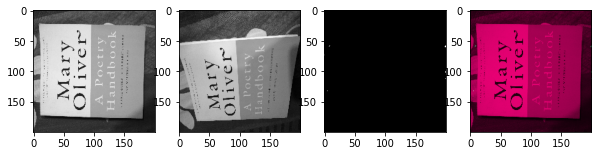

In [ ]:
t2 , c2  = create_result(fixed_image , moving_image , tx)
fig , (ax1 , ax2  ,ax3 , ax4) = plt.subplots(1 , 4 , figsize = (10,15))
ax1.imshow(sitk.GetArrayFromImage(fixed_image) , cmap = 'gray')
ax2.imshow(sitk.GetArrayFromImage(moving_image), cmap = 'gray')
ax3.imshow(sitk.GetArrayFromImage(t2) , cmap = 'gray')
ax4.imshow(sitk.GetArrayFromImage(c2) , cmap = 'gray')